When exploring a large set of documents -- such as Wikipedia, news articles, StackOverflow, etc. 
-- it can be useful to get a list of related material. To find relevant documents you typically

    Decide on a notion of similarity
    Find the documents that are most similar

In [1]:
import sframe
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix      # sparse matrices
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

[INFO] sframe.cython.cy_server: SFrame v2.0.1 started. Logging /tmp/sframe_server_1472353388.log
INFO:sframe.cython.cy_server:SFrame v2.0.1 started. Logging /tmp/sframe_server_1472353388.log


## Load Wikipedia dataset¶

Each element of the dataset consists of a link to the wikipedia article, the name of the person, and the text of the article (in lowercase). The text of each of the article has been reduced to include around the first 400 words. 

In [2]:
wiki = sframe.SFrame('people_wiki.gl')
wiki = wiki.add_row_number()             # add row number, starting at 0

In [3]:
wiki.export_csv('wiki.csv', delimiter=', ', line_terminator='\n', header=True)

In [5]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix( (data, indices, indptr), shape)

In [18]:
def unpack_dict(matrix, map_index_to_word):
    data = matrix.data
    indices = matrix.indices
    indptr = matrix.indptr
    
    num_doc = matrix.shape[0]

    return [{k:v for k,v in zip([map_index_to_word[word_id] for word_id in indices[indptr[i]:indptr[i+1]] ],
                                 data[indptr[i]:indptr[i+1]].tolist())} \
               for i in xrange(num_doc) ]

In [3]:
# Comptue length of all documents
def compute_length(row):
    return len(row['text'].split(' '))

In [10]:
wiki

id,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell> ...,Digby Morrell,digby morrell born 10october 1979 is a former ...
1,<http://dbpedia.org/resource/Alfred_J._Lewy> ...,Alfred J. Lewy,alfred j lewy aka sandylewy graduated from ...
2,<http://dbpedia.org/resource/Harpdog_Brown> ...,Harpdog Brown,harpdog brown is a singerand harmonica player who ...
3,<http://dbpedia.org/resource/Franz_Rottensteiner> ...,Franz Rottensteiner,franz rottensteiner bornin waidmannsfeld lower ...
4,<http://dbpedia.org/resource/G-Enka> ...,G-Enka,henry krvits born 30december 1974 in tallinn ...
5,<http://dbpedia.org/resource/Sam_Henderson> ...,Sam Henderson,sam henderson bornoctober 18 1969 is an ...
6,<http://dbpedia.org/resource/Aaron_LaCrate> ...,Aaron LaCrate,aaron lacrate is anamerican music producer ...
7,<http://dbpedia.org/resource/Trevor_Ferguson> ...,Trevor Ferguson,trevor ferguson aka johnfarrow born 11 november ...
8,<http://dbpedia.org/resource/Grant_Nelson> ...,Grant Nelson,grant nelson born 27april 1971 in london ...
9,<http://dbpedia.org/resource/Cathy_Caruth> ...,Cathy Caruth,cathy caruth born 1955 isfrank h t rhodes ...


In [20]:
vectorizer = TfidfVectorizer()
tf_idf = vectorizer.fit_transform(wiki['text'])

In [8]:
map_word_to_index = vectorizer.vocabulary_

In [15]:
map_index_to_word = dict(zip(map_word_to_index.values(), map_word_to_index.keys()))

In [91]:
vectorizer.get_feature_names()[534918]

u'work'

In [ ]:
idf = vectorizer.idf_
print dict(zip(vectorizer.get_feature_names(), idf))

In [21]:
#tf_idf = vectorizer
wiki['tf_idf'] = unpack_dict(tf_idf, map_index_to_word)

In [23]:
wiki['length'] = wiki.apply(compute_length)

In [24]:
print wiki[wiki['name'] == 'Barack Obama']

+-------+-------------------------------+--------------+
|   id  |              URI              |     name     |
+-------+-------------------------------+--------------+
| 35817 | <http://dbpedia.org/resour... | Barack Obama |
+-------+-------------------------------+--------------+
+-------------------------------+-------------------------------+--------+
|              text             |             tf_idf            | length |
+-------------------------------+-------------------------------+--------+
| barack hussein obama ii br... | {'operations': 0.033592360... |  540   |
+-------------------------------+-------------------------------+--------+
[? rows x 6 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.


In [ ]:
wiki['tf_idf'][35817]

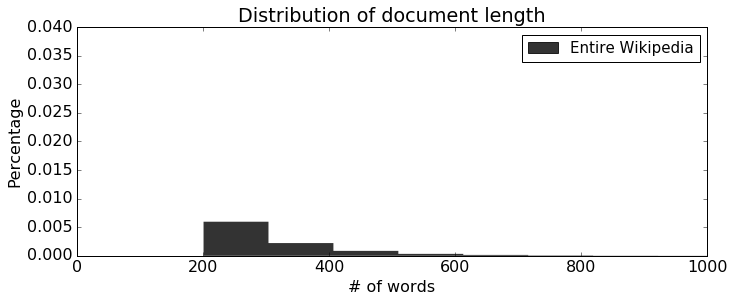

In [42]:
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', normed=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.axis([0, 1000, 0, 0.04])

plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [30]:
model2_tf_idf = NearestNeighbors(algorithm='brute', metric='cosine',n_neighbors = 20)
model2_tf_idf.fit(tf_idf)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=20, p=2, radius=1.0)

In [41]:
distances, indices = model2_tf_idf.kneighbors(tf_idf[34710], n_neighbors=100)
neighbors = sframe.SFrame({'distance':distances.flatten(), 'id':indices.flatten()})
nearest_neighbors_cosine = wiki.join(neighbors, on='id')[['id', 'name', 'length', 'distance']].sort('distance')
print nearest_neighbors_cosine

+-------+--------------------------+--------+-------------------+
|   id  |           name           | length |      distance     |
+-------+--------------------------+--------+-------------------+
| 34710 |        Tom Carper        |  358   | -4.4408920985e-16 |
| 22959 |     Brian Bushweller     |  219   |   0.613974191658  |
| 19152 |      Michael Castle      |  284   |   0.670189263363  |
| 17275 | Joseph James Farnan, Jr. |  208   |   0.705142119076  |
| 52242 |        Tom Harkin        |  222   |   0.714676836098  |
|  6507 |       Bob Menendez       |  220   |   0.738495473367  |
| 23309 |       Chris Coons        |  336   |   0.741782812843  |
| 53724 |    Chadwick A. Tolman    |  439   |   0.74380871753   |
| 25762 |      Susan Collins       |  264   |   0.746603067032  |
| 53433 |      John F. Brady       |  351   |   0.747722324226  |
+-------+--------------------------+--------+-------------------+
[100 rows x 4 columns]
Note: Only the head of the SFrame is printed.
You can

id,URI,name,text,tf_idf
0,<http://dbpedia.org/resource/Digby_Morrell> ...,Digby Morrell,digby morrell born 10october 1979 is a former ...,"{'selection':0.04887476243770766, ..."
1,<http://dbpedia.org/resource/Alfred_J._Lewy> ...,Alfred J. Lewy,alfred j lewy aka sandylewy graduated from ...,"{'precise':0.06614354221841966, ..."
2,<http://dbpedia.org/resource/Harpdog_Brown> ...,Harpdog Brown,harpdog brown is a singerand harmonica player who ...,"{'just':0.04288490175290481, ..."
3,<http://dbpedia.org/resource/Franz_Rottensteiner> ...,Franz Rottensteiner,franz rottensteiner bornin waidmannsfeld lower ...,"{'englishreading':0.08607762990029681, ..."
4,<http://dbpedia.org/resource/G-Enka> ...,G-Enka,henry krvits born 30december 1974 in tallinn ...,"{'legendary':0.044093408541336546, ..."
5,<http://dbpedia.org/resource/Sam_Henderson> ...,Sam Henderson,sam henderson bornoctober 18 1969 is an ...,"{'currently':0.024434226296184382, ..."
6,<http://dbpedia.org/resource/Aaron_LaCrate> ...,Aaron LaCrate,aaron lacrate is anamerican music producer ...,"{'exclusive':0.05892372971323588, ..."
7,<http://dbpedia.org/resource/Trevor_Ferguson> ...,Trevor Ferguson,trevor ferguson aka johnfarrow born 11 november ...,"{'taxi':0.0455916161131555, ..."
8,<http://dbpedia.org/resource/Grant_Nelson> ...,Grant Nelson,grant nelson born 27april 1971 in london ...,"{'houston':0.04824820528169965, ..."
9,<http://dbpedia.org/resource/Cathy_Caruth> ...,Cathy Caruth,cathy caruth born 1955 isfrank h t rhodes ...,"{'phenomenon':0.06969980903859993, ..."
